# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
import glob
path = glob.glob('./**/Banana.exe', recursive=True)[0]

In [3]:
env = UnityEnvironment(file_name=path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


**States are ever featured. Convolutional layers are not useful here because input are not images. Optional chalenge (pixel input) will add the convolutional layers.** 

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
step_nbr = 0
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    step_nbr += 1
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
print("Nbr of step for this episode: {}".format(step_nbr))

Score: 0.0
Nbr of step for this episode: 300


Each episode is done after 300 steps. That means during the training, each episode will run at term. 

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

Import the useful libraries

In [7]:
import torch
from collections import deque
from dqn_agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

### Training

In [27]:
def train_dqn(agent, env, brain_name, n_episodes=2000, max_t=1000, eps_start=1., eps_end=0.01, eps_decay=0.9945,
              save=False, target=20.):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        save (boolean): save or not the model
        target (float) : score threshold to consider that the model is completely trained
    """
    scores = []                        # list containing scores from each episode
    scores_avg = []                    # list containing average scores over 100 episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            scores_avg.append(np.mean(scores_window))
            if save:
                torch.save(agent.qnetwork_local.state_dict(), 'checkpointep{}.pt'.format(i_episode))
        if np.mean(scores_window)>=target:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            scores_avg.append(np.mean(scores_window))
            if save:
                torch.save(agent.qnetwork_local.state_dict(), 'model.pt')
                break
    return scores, scores_avg

This function and python scripts are coming from DQN lesson exercice with the following parameters:

* BUFFER_SIZE = **int(1e5)**                # replay buffer size
* BATCH_SIZE = **64**                      # minibatch size
* GAMMA = **0.99**                          # discount factor
* TAU = **5e-4**              # for soft update of target parameters
* TAU_STEP = **4000**         # for hard update of target parameters
* LR = **5e-4**               # learning rate 
* UPDATE_EVERY = **4**        # how often to update the network

Network implemented:

![network](./network.png)

#### DQN (with fixed Q-target) 

Here we train the model without improvement and report the result. 

fixed Q-target means that target network is updated every 4000 steps (every 14 episodes).

Network is inspired by [this paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

Episode 100	Average Score: 1.34
Episode 200	Average Score: 5.07
Episode 300	Average Score: 8.21
Episode 400	Average Score: 11.40
Episode 500	Average Score: 11.73
Episode 600	Average Score: 14.08
Episode 700	Average Score: 14.25
Episode 800	Average Score: 13.83
Episode 900	Average Score: 15.83
Episode 1000	Average Score: 16.21
Episode 1100	Average Score: 15.37
Episode 1200	Average Score: 15.33
Episode 1300	Average Score: 14.43
Episode 1400	Average Score: 15.27
Episode 1500	Average Score: 14.55
Episode 1600	Average Score: 14.87
Episode 1700	Average Score: 14.24
Episode 1800	Average Score: 15.47
Episode 1900	Average Score: 15.52
Episode 2000	Average Score: 13.96


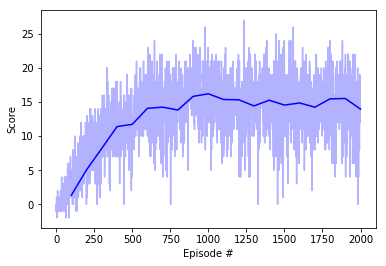

In [10]:
scores1, scores_avg1 = train_dqn(agent, env, brain_name)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores1)), scores1, alpha=0.3, color = 'b')
plt.plot(np.append(np.arange(1,len(scores_avg1))*100 ,len(scores1)), scores_avg1, color = 'b')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### DQN (soft update method) 

Here we train the model by using soft update method. Rather than updates the target network every 4000 steps, we update it everystep but with inertness according to the formula:
θ_target = τ*θ_local + (1 - τ)*θ_target

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, improvements=['soft_update'])

soft uptade activated


Episode 100	Average Score: 0.90
Episode 200	Average Score: 4.07
Episode 300	Average Score: 7.31
Episode 400	Average Score: 9.28
Episode 500	Average Score: 10.76
Episode 600	Average Score: 13.05
Episode 700	Average Score: 14.52
Episode 800	Average Score: 14.82
Episode 900	Average Score: 15.22
Episode 1000	Average Score: 15.98
Episode 1100	Average Score: 15.83
Episode 1200	Average Score: 16.23
Episode 1300	Average Score: 16.53
Episode 1400	Average Score: 16.12
Episode 1500	Average Score: 15.41
Episode 1600	Average Score: 15.29
Episode 1700	Average Score: 16.19
Episode 1800	Average Score: 16.48
Episode 1900	Average Score: 16.96
Episode 2000	Average Score: 16.42


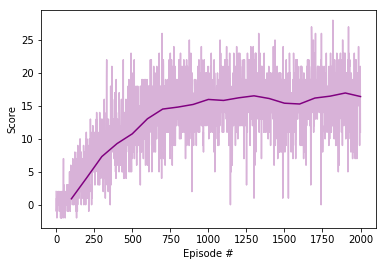

In [12]:
scores2, scores_avg2 = train_dqn(agent, env, brain_name)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores2)), scores2, alpha=0.3, color = 'purple')
plt.plot(np.append(np.arange(1,len(scores_avg2))*100 ,len(scores2)), scores_avg2, color = 'purple')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Double DQN

Double DQN is an improvement easily implementable. This method handles the problem of the overestimation of Q-values.
when we compute the Q target, we use two networks to decouple the action selection from the target Q value generation. We:

* use our DQN network to select what is the best action to take for the next state (the action with the highest Q value).
* use our target network to calculate the target Q value of taking that action at the next state.

[Research paper](https://arxiv.org/abs/1509.06461)

In [13]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, improvements=['soft_update', 'DoubleDQN'])

soft uptade activated
Double DQN activated


Episode 100	Average Score: 0.24
Episode 200	Average Score: 2.16
Episode 300	Average Score: 5.54
Episode 400	Average Score: 7.62
Episode 500	Average Score: 11.17
Episode 600	Average Score: 11.92
Episode 700	Average Score: 15.24
Episode 800	Average Score: 16.73
Episode 900	Average Score: 16.34
Episode 1000	Average Score: 15.96
Episode 1100	Average Score: 16.65
Episode 1200	Average Score: 15.91
Episode 1300	Average Score: 16.12
Episode 1400	Average Score: 16.24
Episode 1500	Average Score: 17.56
Episode 1600	Average Score: 17.05
Episode 1700	Average Score: 16.84
Episode 1800	Average Score: 16.60
Episode 1900	Average Score: 16.36
Episode 2000	Average Score: 16.27


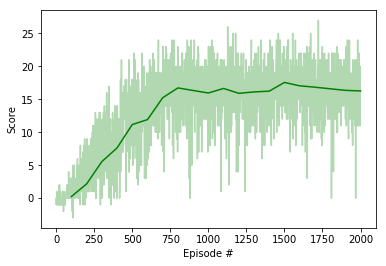

In [14]:
scores3, scores_avg3 = train_dqn(agent, env, brain_name)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores3)), scores3, alpha=0.3, color = 'green')
plt.plot(np.append(np.arange(1,len(scores_avg3))*100 ,len(scores3)), scores_avg3, color = 'green')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Prioritized Experience Replay

PER is a improvement more complicate to implement.

The idea is that some experiences may be more important than others for our training, but might occur less frequently.

Because we sample the batch uniformly (selecting the experiences randomly) these rich experiences that occur rarely have practically no chance to be selected.

That’s why, with PER, we try to change the sampling distribution by using a criterion to define the priority of each tuple of experience.

We want to take in priority experience where there is a big difference between our prediction and the TD target, since it means that we have a lot to learn about it.

We will use a sum tree to select batches.

![sumtree](./sumtree.png)

[Reseach paper](https://arxiv.org/abs/1511.05952)

**Comment:**

Improvement is not visible for this problem. Some doubts about implementation are possible.

In [15]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, improvements=['soft_update', 'PER'])

soft uptade activated
Prioritized Experience Replay activated


Episode 100	Average Score: 0.55
Episode 200	Average Score: 2.77
Episode 300	Average Score: 6.38
Episode 400	Average Score: 9.24
Episode 500	Average Score: 11.23
Episode 600	Average Score: 13.51
Episode 700	Average Score: 14.07
Episode 800	Average Score: 15.71
Episode 900	Average Score: 15.56
Episode 1000	Average Score: 16.24
Episode 1100	Average Score: 15.88
Episode 1200	Average Score: 15.57
Episode 1300	Average Score: 16.70
Episode 1400	Average Score: 16.43
Episode 1500	Average Score: 16.25
Episode 1600	Average Score: 15.96
Episode 1700	Average Score: 16.42
Episode 1800	Average Score: 16.11
Episode 1900	Average Score: 16.49
Episode 2000	Average Score: 15.95


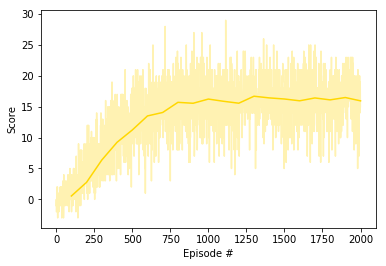

In [16]:
scores4, scores_avg4 = train_dqn(agent, env, brain_name)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores4)), scores4, alpha=0.3, color = 'gold')
plt.plot(np.append(np.arange(1,len(scores_avg4))*100 ,len(scores4)), scores_avg4, color = 'gold')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Dueling DQN

Here we use the Dueling DQN improvement.

Q-values correspond to how good it is to be at that state and taking an action at that state Q(s,a).

So we can decompose Q(s,a) as the sum of:

* V(s): the value of being at that state
* A(s,a): the advantage of taking that action at that state (how much better is to take this action versus all other possible actions at that state).

With DDQN, we want to separate the estimator of these two elements, using two new streams:

* one that estimates the state value V(s)
* one that estimates the advantage for each action A(s,a)

![Dueling](./dueling1.png)

[Research paper](https://arxiv.org/abs/1511.06581)

**Comment**

Here, I have been not sure if I have to add a RELU function between the both networks and the agregating layer. Solution seems to be that no RELU function has to be used just before agregating layer.

In [17]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, improvements=['soft_update', 'DuelingDQN'])

soft uptade activated
Dueling DQN activated


Episode 100	Average Score: 0.52
Episode 200	Average Score: 4.01
Episode 300	Average Score: 6.70
Episode 400	Average Score: 9.42
Episode 500	Average Score: 12.06
Episode 600	Average Score: 14.19
Episode 700	Average Score: 14.34
Episode 800	Average Score: 14.72
Episode 900	Average Score: 15.30
Episode 1000	Average Score: 15.79
Episode 1100	Average Score: 15.80
Episode 1200	Average Score: 14.94
Episode 1300	Average Score: 15.74
Episode 1400	Average Score: 16.01
Episode 1500	Average Score: 15.55
Episode 1600	Average Score: 16.09
Episode 1700	Average Score: 15.54
Episode 1800	Average Score: 15.21
Episode 1900	Average Score: 15.68
Episode 2000	Average Score: 15.21


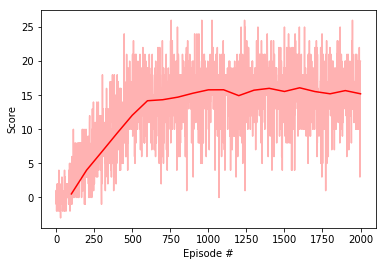

In [18]:
scores5, scores_avg5 = train_dqn(agent, env, brain_name)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores5)), scores5, alpha=0.3, color = 'red')
plt.plot(np.append(np.arange(1,len(scores_avg5))*100 ,len(scores5)), scores_avg5, color = 'red')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Rainbow

Here we will use all the improvement together. What is called "rainbow"

In [28]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, improvements=['soft_update', 
                                                                                    'DoubleDQN', 'PER', 'DuelingDQN'])

soft uptade activated
Double DQN activated
Prioritized Experience Replay activated
Dueling DQN activated


In [29]:
scores6, scores_avg6 = train_dqn(agent, env, brain_name)

Episode 100	Average Score: 0.12
Episode 200	Average Score: 2.08
Episode 300	Average Score: 5.52
Episode 400	Average Score: 7.78
Episode 500	Average Score: 9.58
Episode 600	Average Score: 13.70
Episode 700	Average Score: 14.81
Episode 800	Average Score: 15.50
Episode 900	Average Score: 16.36
Episode 1000	Average Score: 16.37
Episode 1100	Average Score: 16.46
Episode 1200	Average Score: 16.36
Episode 1300	Average Score: 16.55
Episode 1400	Average Score: 16.08
Episode 1500	Average Score: 16.04
Episode 1600	Average Score: 16.37
Episode 1700	Average Score: 14.88
Episode 1800	Average Score: 16.18
Episode 1900	Average Score: 15.67
Episode 2000	Average Score: 15.56


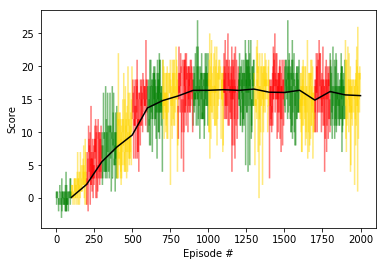

In [30]:
# plot the scores
from matplotlib.collections import LineCollection
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(len(scores6))
y = scores6
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
cm = dict(zip(range(0,3),['green', 'gold', 'red']))
colors = list( map( cm.get , x//100%3  ))
lc = LineCollection(segments, colors=colors, alpha=0.3)
ax.add_collection(lc)
plt.plot(np.append(np.arange(1,len(scores_avg6))*100 ,len(scores6)), scores_avg6, color = 'black')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Resume

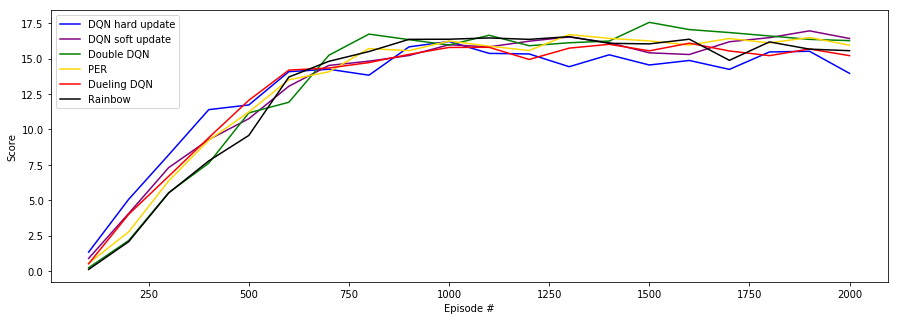

In [31]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
plt.plot(np.append(np.arange(1,len(scores_avg1))*100 ,len(scores1)), scores_avg1, color = 'b', label='DQN hard update')
plt.plot(np.append(np.arange(1,len(scores_avg2))*100 ,len(scores2)), scores_avg2, color = 'purple', label='DQN soft update')
plt.plot(np.append(np.arange(1,len(scores_avg3))*100 ,len(scores3)), scores_avg3, color = 'green', label='Double DQN')
plt.plot(np.append(np.arange(1,len(scores_avg4))*100 ,len(scores4)), scores_avg4, color = 'gold', label='PER')
plt.plot(np.append(np.arange(1,len(scores_avg5))*100 ,len(scores2)), scores_avg5, color = 'red', label='Dueling DQN')
plt.plot(np.append(np.arange(1,len(scores_avg6))*100 ,len(scores6)), scores_avg6, color = 'black', label='Rainbow')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

For this challenge, improvements are not really obvious. But Double DQN and soft update seems to be better solution.

### Save the model

Here we choose a model with improvements:
* soft update
* Double DQN
* Dueling DQN

Then we save the model when we reach the target score of 17 (mean of 100 episodes).

Also, we save model at intermediary step (each 100 episode) in order to display the learning process.

In [32]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, improvements=['soft_update', 
                                                                                    'DoubleDQN', 'DuelingDQN'])
scores, scores_avg = train_dqn(agent, env, brain_name, save=True, target=17.0)

soft uptade activated
Double DQN activated
Dueling DQN activated
Episode 100	Average Score: 0.80
Episode 200	Average Score: 4.48
Episode 300	Average Score: 7.88
Episode 400	Average Score: 10.09
Episode 500	Average Score: 11.83
Episode 600	Average Score: 13.72
Episode 700	Average Score: 13.63
Episode 800	Average Score: 14.46
Episode 900	Average Score: 16.04
Episode 1000	Average Score: 15.80
Episode 1100	Average Score: 15.92
Episode 1200	Average Score: 15.97
Episode 1300	Average Score: 16.23
Episode 1400	Average Score: 15.97
Episode 1500	Average Score: 16.27
Episode 1600	Average Score: 17.05

Environment solved in 1500 episodes!	Average Score: 17.05


### Testing

#### Wath the agent

In [33]:
import time

In [34]:
def test_dqn(agent, env, brain_name, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        max_t (int): maximum number of timesteps per episode
    """
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state)                      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break

    return score

#### trained agent

In [35]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('model.pt'))
time.sleep(10)
score = test_dqn(agent, env, brain_name)    
print("Score: {}".format(score))

Score: 19.0


##### Gifed output

![gif1](./finalagent.gif)

#### After 100 episodes

In [43]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpointep100.pt'))
time.sleep(10)
score = test_dqn(agent, env, brain_name)    
print("Score: {}".format(score))

Score: 0.0


##### Gifed output

![gif2](./100episodes.gif)

#### After 500 episodes

In [42]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpointep500.pt'))
time.sleep(10)
score = test_dqn(agent, env, brain_name)    
print("Score: {}".format(score))

Score: 11.0


##### Gifed output

![gif3](./500episodes.gif)

#### Other example for 500 episodes

![gif4](./500episodesother.gif)

When finished, you can close the environment.

In [45]:
env.close()

## Discusion

Network works correctly and learns to navigate between yellow and blue bananas. We can see that there are some easy situations and complex situations (when blue bananas surrounds the agent). Some complex situation make blocking the agent in an inappropriate policy. Improvement could be to distinguish complex situation to prioritize it. PER prioritize the infrequent situation not the complex one. 

Second point is model could be improve by : a better parameter optimization, an other network architecture, dropout, regularization, ...